<a href="https://colab.research.google.com/github/gapradana123/cnn-klasifikasi-bunga/blob/main/Dicoding_Proyek_Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Flower Dataset
- **Nama:** Gregorius Adi Pradana
- **Email:** gapradana123@gmail.com
- **ID Dicoding:** [Input Username]

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [2]:
# Upload file token kaggle untuk terhubung dengan API Kaggle
#from google.colab import files
#files.upload()

In [3]:
# Download dataset kaggle dan unzip
!kaggle datasets download -d junkal/flowerdatasets
!unzip flowerdatasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/train/rose/370872334_4765d8b086_o.jpg  
  inflating: flowers/train/rose/37135456215_8ee0e71fbc_k.jpg  
  inflating: flowers/train/rose/37209953126_87b1ddff10_k.jpg  
  inflating: flowers/train/rose/37216485931_0e0d232fcd_k.jpg  
  inflating: flowers/train/rose/37236772855_eb2f32b1af_k.jpg  
  inflating: flowers/train/rose/37421104851_9f66cda177_k.jpg  
  inflating: flowers/train/rose/37451725494_21db5e7ea8_k.jpg  
  inflating: flowers/train/rose/37526965574_ae6b1159bf_k.jpg  
  inflating: flowers/train/rose/37537007156_07aaad7f31_k.jpg  
  inflating: flowers/train/rose/3769935473_4a141ee8e8_o.jpg  
  inflating: flowers/train/rose/37867371406_89de9f78d4_k.jpg  
  inflating: flowers/train/rose/3792450522_0df34f72ba_o.jpg  
  inflating: flowers/train/rose/38039351116_d2e58ab616_k.jpg  
  inflating: flowers/train/rose/3809855717_236c49c712_o.jpg  
  inflating: flowers/train/rose/38276818756_63e4b6efae_k.jpg  
  inflati

In [4]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = 'flowers/train'
val_dir = 'flowers/val'
test_dir = 'flowers/test'

# Direktori baru untuk dataset gabungan
combined_dir = 'flowers/dataset'

In [5]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Fungsi untuk menyalin file dari src_dir ke dest_dir
def copy_files(src_dir, dest_dir):
  for category in os.listdir(src_dir):
    cat_src_dir = os.path.join(src_dir, category)
    cat_dest_dir = os.path.join(dest_dir, category)
    if os.path.isdir(cat_src_dir):
      shutil.copytree(cat_src_dir, cat_dest_dir, dirs_exist_ok=True)


copy_files(train_dir, combined_dir)  # Salin file dari train_dir ke combined_dir
copy_files(val_dir, combined_dir)    # Salin file dari val_dir ke combined_dir
copy_files(test_dir, combined_dir)   # Salin file dari test_dir ke combined_dir

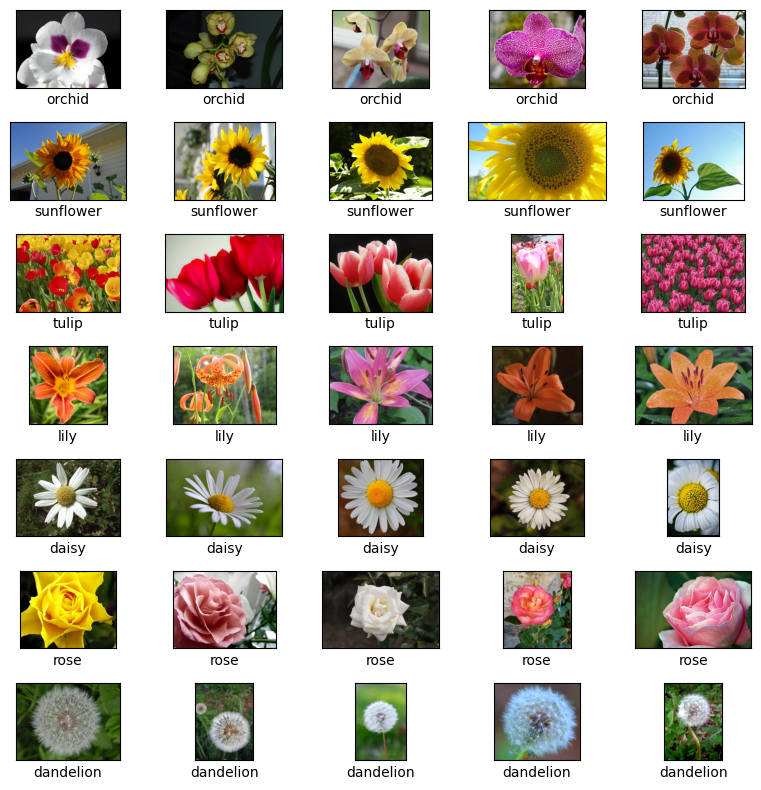

In [6]:
# Mencatat seluruh nama file untuk setiap kategori dalam dictionary 'images'
images = {}
for category in os.listdir(combined_dir):
  category_dir = os.path.join(combined_dir, category)
  images[category] = os.listdir(category_dir)

# Menampilkan secara acak 5 gambar untuk setiap kategori dalam dataset.
fig, axs = plt.subplots(len(images.keys()), 5, figsize=(8, 8))

for i, class_name in enumerate(os.listdir(combined_dir)):
    sample_images = np.random.choice(images[class_name], 5, replace=False)

    for j, image_name in enumerate(sample_images):
        img_path = os.path.join(combined_dir, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

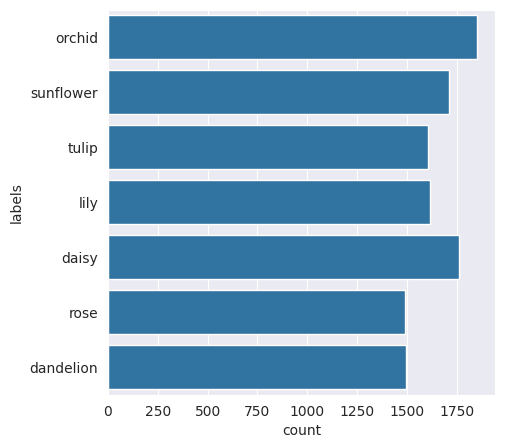

In [7]:
file_name = []
labels = []
full_path = []

# Mendapatkan filenames, filepaths, dan labels
for path, subdirs, files in os.walk(combined_dir):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

dataset_df = pd.DataFrame({'path':full_path,'file_name':file_name,'labels':labels})

# Plot distribusi citra untuk setiap kelas
Label = dataset_df['labels']
plt.figure(figsize = (5,5))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [8]:
# Jumlah data masing-masing label
dataset_df['labels'].value_counts()

labels
orchid       1851
daisy        1759
sunflower    1713
lily         1618
tulip        1606
dandelion    1495
rose         1489
Name: count, dtype: int64

### Data Preprocessing

#### Split Dataset

In [9]:
# Split data (filepath) dan label
X = dataset_df['path']
y = dataset_df['labels']

# Split dataset awal menjadi data train, valid, dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=300)

In [10]:
# Menyatukan kedalam masing-masing dataframe
train_df = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
valid_df = pd.DataFrame({'path':X_valid,'labels':y_valid,'set':'valid'})
test_df = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

# Gabungkan DataFrame df_tr dan df_te
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

# Jumlah data train, valid, dan test
combined_df['set'].value_counts()

set
train    7379
test     2307
valid    1845
Name: count, dtype: int64

In [11]:
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

for index, row in tq(combined_df.iterrows()):
  src_file_path = row['path']                                              # File path sumber
  file_name = src_file_path.split('/')[-1]                                 # File name
  destination_dir = os.path.join(dataset_path, row['set'], row['labels'])  # Direktori tujuan
  dest_file_path = os.path.join(destination_dir, file_name)                # File path tujuan

  # Jika direktori tujuan belum ada maka buat direktori tujuan
  if os.path.exists(destination_dir) == False:
    os.makedirs(destination_dir)

  # Jika file tujuan belum ada maka copy file dari sumber ke tujuan
  if os.path.exists(dest_file_path) == False:
    shutil.copy2(src_file_path, dest_file_path)

0it [00:00, ?it/s]

In [12]:
# Direktori data training dan testing
TRAIN_DIR = 'Dataset-Final/train'
VALID_DIR = 'Dataset-Final/valid'
TEST_DIR = 'Dataset-Final/test'

# Fungsi untuk menghitung jumlah data pada directory
def data_amount(DIR):
  dir_name = DIR.split('/')[-1]
  for category in os.listdir(DIR):
    category_dir = os.path.join(DIR, category)
    print(f'{dir_name} {category} : {len(os.listdir(category_dir))}')

data_amount(TRAIN_DIR)
data_amount(VALID_DIR)
data_amount(TEST_DIR)

train orchid : 1205
train sunflower : 1093
train tulip : 1032
train lily : 1018
train daisy : 1133
train rose : 963
train dandelion : 935
valid orchid : 273
valid sunflower : 304
valid tulip : 242
valid lily : 254
valid daisy : 289
valid rose : 233
valid dandelion : 250
test orchid : 373
test sunflower : 316
test tulip : 332
test lily : 346
test daisy : 337
test rose : 293
test dandelion : 310


#### Augmentasi Citra

In [13]:
# Membuat image data generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [14]:
# Memuat citra ke dalam generator
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    batch_size=128,
                                                    target_size=(128, 128),
                                                    color_mode='rgb',
                                                    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(VALID_DIR,
                                                         batch_size=128,
                                                         target_size=(128, 128),
                                                         color_mode='rgb',
                                                         class_mode='categorical')

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=128,
                                                  target_size=(128, 128),
                                                  color_mode='rgb',
                                                  class_mode='categorical')

Found 7379 images belonging to 7 classes.
Found 1845 images belonging to 7 classes.
Found 2307 images belonging to 7 classes.


In [15]:
# Mendapatkan dictionary kelas dari dataset latih
classes_dict = dict(train_generator.class_indices)
classes_dict = {v: k for k,v in classes_dict.items()}
classes_dict

{0: 'daisy',
 1: 'dandelion',
 2: 'lily',
 3: 'orchid',
 4: 'rose',
 5: 'sunflower',
 6: 'tulip'}

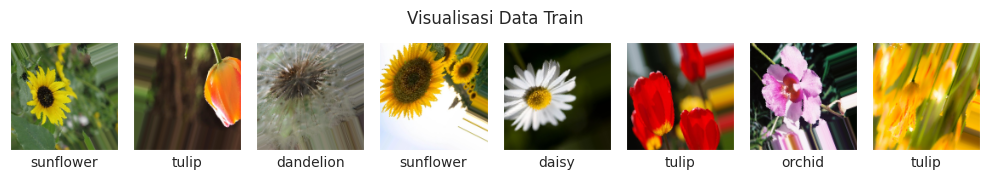

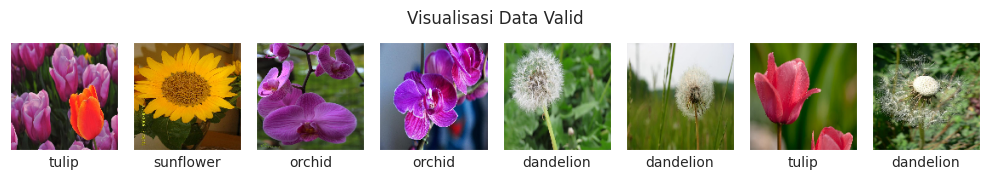

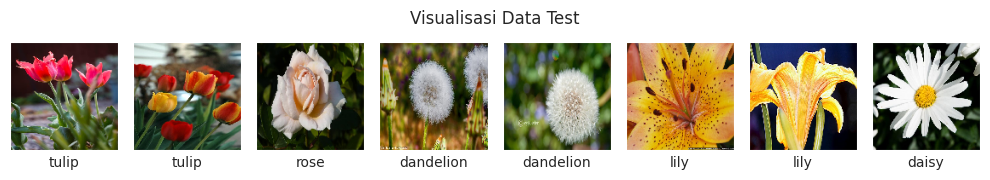

In [16]:
# Fungsi untuk menampilkan 8 citra
def show_images(images, labels, classes_dict, title):
  fig, axs = plt.subplots(1, 8, figsize=(10, 10))
  for i in range(8):
    classes = np.argmax(labels[i])
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set(xlabel=classes_dict[classes], xticks=[], yticks=[])
  fig.suptitle(title, y=0.57)
  fig.tight_layout()

# Generate data train dan valid
X_train, y_train = train_generator.next()
X_valid, y_valid = validation_generator.next()
X_test, y_test = test_generator.next()

# Menampilkan 8 citra dari data train, valid, dan test
show_images(X_train, y_train, classes_dict, 'Visualisasi Data Train')
show_images(X_valid, y_valid, classes_dict, 'Visualisasi Data Valid')
show_images(X_test, y_test, classes_dict, 'Visualisasi Data Test')

## Modelling

In [ ]:
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.utils import plot_model

In [ ]:
plot_model(myModel, show_layer_names=False, show_shapes=True, dpi=70)

In [ ]:
# Memuat model pre-trained ResNet50, tanpa layer klasifikasinya (dense)
base_model = VGG16(input_shape=(224, 224, 3), include_top=True, weights='imagenet')

# Freeze bobot dari base model
base_model.trainable = True

# Membuat model dengan pre-trained model yang di cut
myModel = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

myModel.summary()

In [ ]:
# Buat model baru menggunakan base model
model = tf.keras.Sequential([
    myModel,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

# Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

# Menampilkan summary model
model.summary()

In [17]:
# Definisi Model
model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(32, (4,4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(32, (7,7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

# Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Menampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        16416     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                        

In [18]:
# Mendefinisikan callback
filepath = '/content/model.keras'

model_stopping = EarlyStopping(monitor='val_loss',
                               patience=5)

model_checkpoint = ModelCheckpoint(filepath,
                                   monitor='val_accuracy',
                                   save_best_only=True)
# Melatih model
history = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[model_checkpoint, model_stopping])

Epoch 1/20
58/58 [==============================] - 437s 7s/step - loss: 2.1141 - accuracy: 0.3625 - val_loss: 2.1366 - val_accuracy: 0.1870
Epoch 2/20
58/58 [==============================] - 435s 7s/step - loss: 1.4726 - accuracy: 0.4862 - val_loss: 4.0428 - val_accuracy: 0.2244
Epoch 3/20
28/58 [=============>................] - ETA: 3:22 - loss: 1.3303 - accuracy: 0.5419

KeyboardInterrupt: 

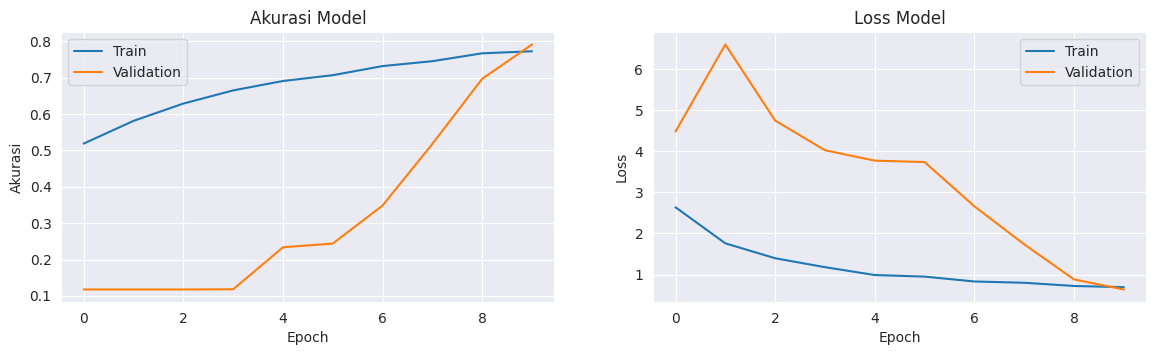

In [ ]:
plt.figure(figsize = (14, 3.5))

# Plot akurasi training dan validation
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plot loss training dan validation
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Evaluasi dan Visualisasi

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
best_model = load_model('/content/model.keras')
scores = best_model.evaluate(test_generator, verbose=1)
print(f'Akurasi model : {scores[1]:.2%}')

19/19 [==============================] - 6s 295ms/step - loss: 0.5706 - accuracy: 0.8153
Akurasi model : 81.53%


## Konversi Model

## Inference (Optional)

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(128,128))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = best_model.predict(images, batch_size=10)
  classes = np.argmax(classes)
  print(fn)
  print(classes_dict[classes])

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  test_img = image.load_img(fn, target_size=(150, 150),color_mode='grayscale')

  # Preprocessing gambar
  pp_test_img = image.img_to_array(test_img)
  pp_test_img = pp_test_img/255
  pp_test_img = np.expand_dims(pp_test_img, axis=0)

  # Prediksi menggunakan data baru
  test_preds= model_5.predict(pp_test_img)

  # Mencetak hasil prediksi
  plt.figure(figsize=(6,6))
  plt.axis('off')
  if test_preds >= 0.5:
      out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(test_preds[0][0]))

  else:
      out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-test_preds[0][0]))
  plt.title("Pneumonia Diseased Image Recognition\n"+out)
  plt.imshow(np.squeeze(pp_test_img))
  plt.show()